# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [ ]:
# Import essential libraries for data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization, built on top of matplotlib
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For preprocessing data and encoding categorical features
from sklearn.linear_model import LinearRegression  # For building linear regression models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # For building ensemble-based regression models
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance


In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [ ]:
# Importing the file porter_data_1.csv
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/content/porter_data_1.csv'
df = pd.read_csv(file_path)

# Inspect the first few rows of the dataframe to ensure proper loading
print(df.head())


   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2 

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [ ]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
import pandas as pd

# Assuming df is your DataFrame
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Verify the conversion
print(df.dtypes[['created_at', 'actual_delivery_time']])



created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [ ]:
# Convert categorical features to category type

df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')

# Verify the conversion
print(df.dtypes[['store_primary_category', 'order_protocol']])

store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [ ]:
# Calculate time taken in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Verify the first few calculations
print(df[['created_at', 'actual_delivery_time', 'delivery_time_minutes']].head())


           created_at actual_delivery_time  delivery_time_minutes
0 2015-02-06 22:24:17  2015-02-06 23:11:17                   47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                   44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                   55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                   59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                   46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [ ]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['isWeekend'] = df['isWeekend'].astype('category')
print(df[['created_at', 'order_hour', 'order_day_of_week', 'isWeekend']].head())


           created_at  order_hour  order_day_of_week isWeekend
0 2015-02-06 22:24:17          22                  4         0
1 2015-02-10 21:49:25          21                  1         0
2 2015-02-16 00:11:35           0                  0         0
3 2015-02-12 03:36:46           3                  3         0
4 2015-01-27 02:12:36           2                  1         0


In [ ]:
# Drop unnecessary columns
columns_to_drop = ['created_at']

# Drop the unnecessary columns
df.drop(columns=columns_to_drop, inplace=True)

# Verify the remaining columns
print(df.head())

   market_id actual_delivery_time store_primary_category order_protocol  \
0        1.0  2015-02-06 23:11:17                      4            1.0   
1        2.0  2015-02-10 22:33:25                     46            2.0   
2        2.0  2015-02-16 01:06:35                     36            3.0   
3        1.0  2015-02-12 04:35:46                     38            1.0   
4        1.0  2015-01-27 02:58:36                     38            1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            4      4771                   3             820            1604   
3            1      1525                   1            1525            1525   
4            2      3620                   2            1425            2195   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orde

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [ ]:
# Define target variable (y) and features (X)
y = df['delivery_time_minutes']

# Define the feature set
X = df.drop(columns=['delivery_time_minutes', 'actual_delivery_time'])

# Verify the shapes of X and y to ensure correct assignment
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Optional: Display the first few rows of X and y to inspect them
print(X.head())
print(y.head())



Features (X) shape: (175777, 15)
Target (y) shape: (175777,)
   market_id store_primary_category order_protocol  total_items  subtotal  \
0        1.0                      4            1.0            4      3441   
1        2.0                     46            2.0            1      1900   
2        2.0                     36            3.0            4      4771   
3        1.0                     38            1.0            1      1525   
4        1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Since we have already converted appropriate columns to 'category' type, we can use this type for selection
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Output the lists to verify
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_minutes']
Categorical columns: ['store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

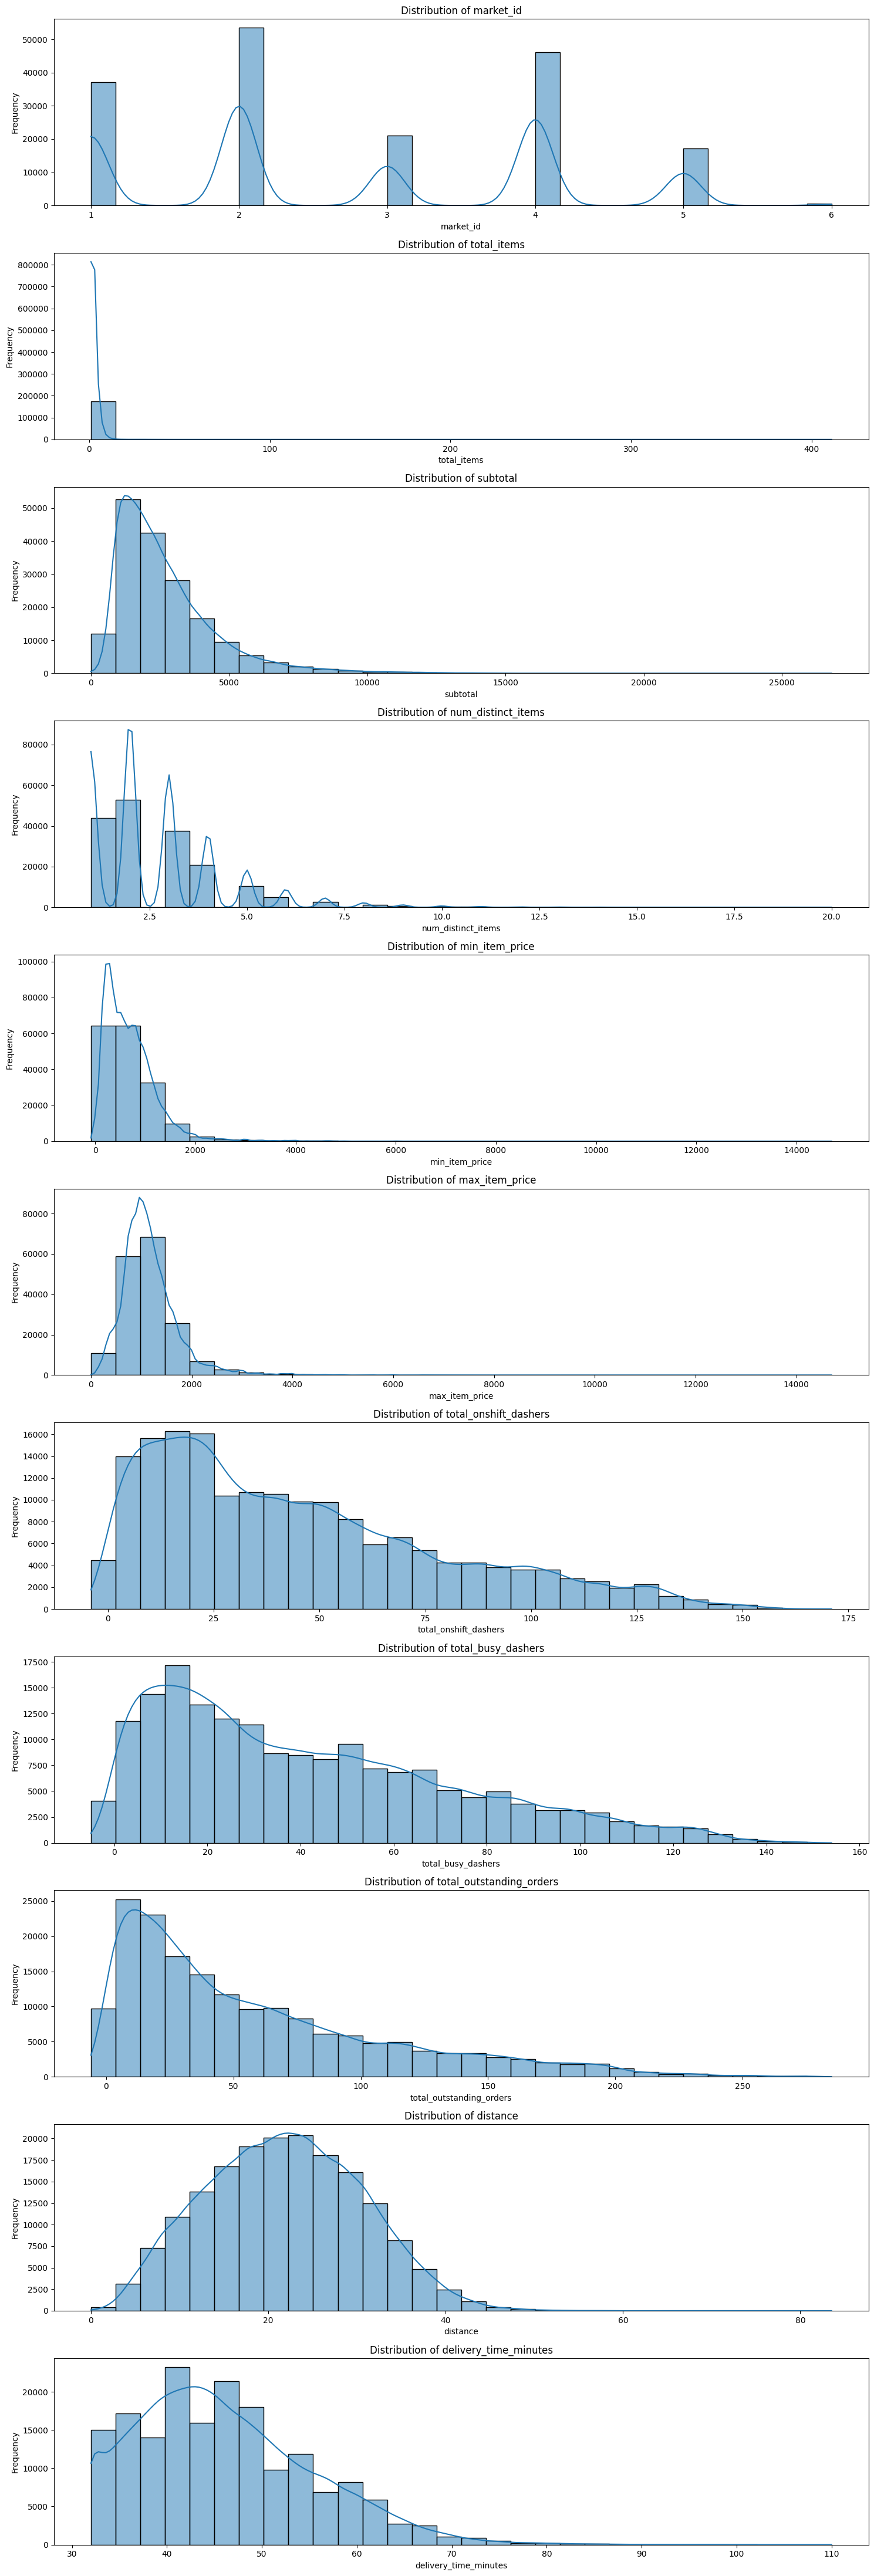

In [ ]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns if not defined already
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(15, len(numerical_cols) * 4))

# Iterate through and plot each numerical column
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

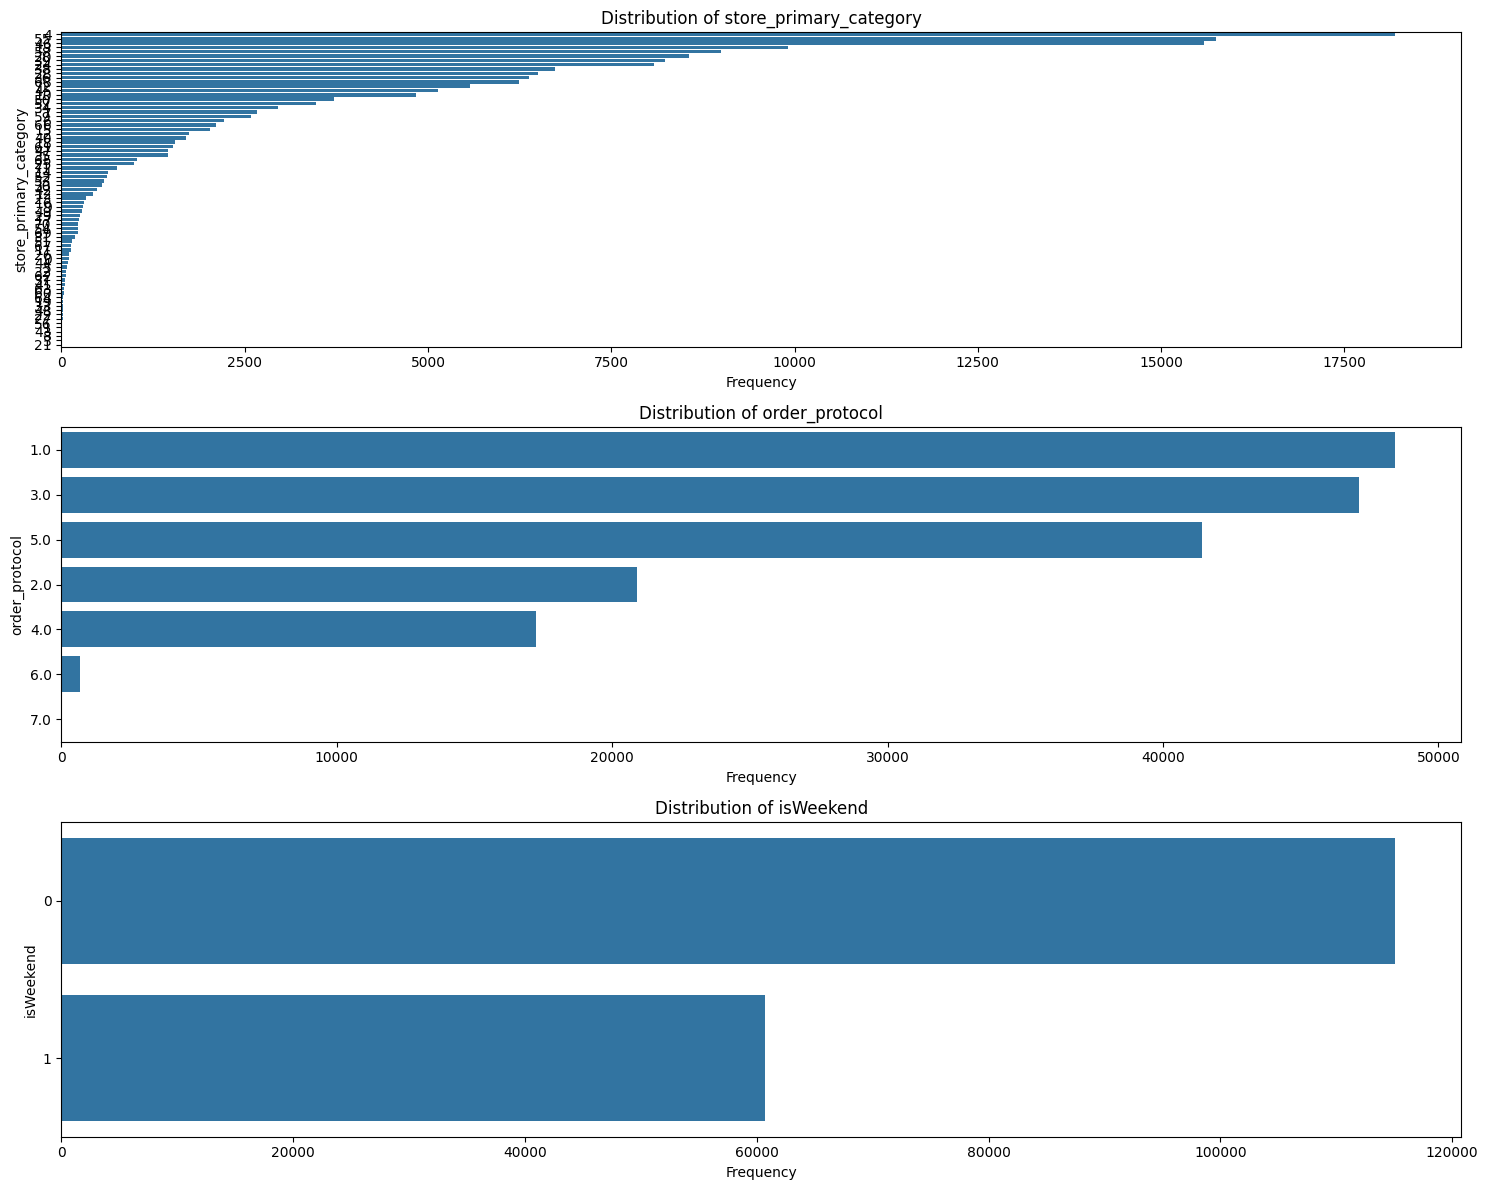

In [ ]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns if not defined already
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(15, len(categorical_cols) * 4))

# Iterate through and plot each categorical column
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.ylabel(col)
    plt.xlabel('Frequency')

plt.tight_layout()
plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of delivery times
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time_minutes'], bins=30, kde=True)
plt.title('Distribution of Delivery Time (in minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

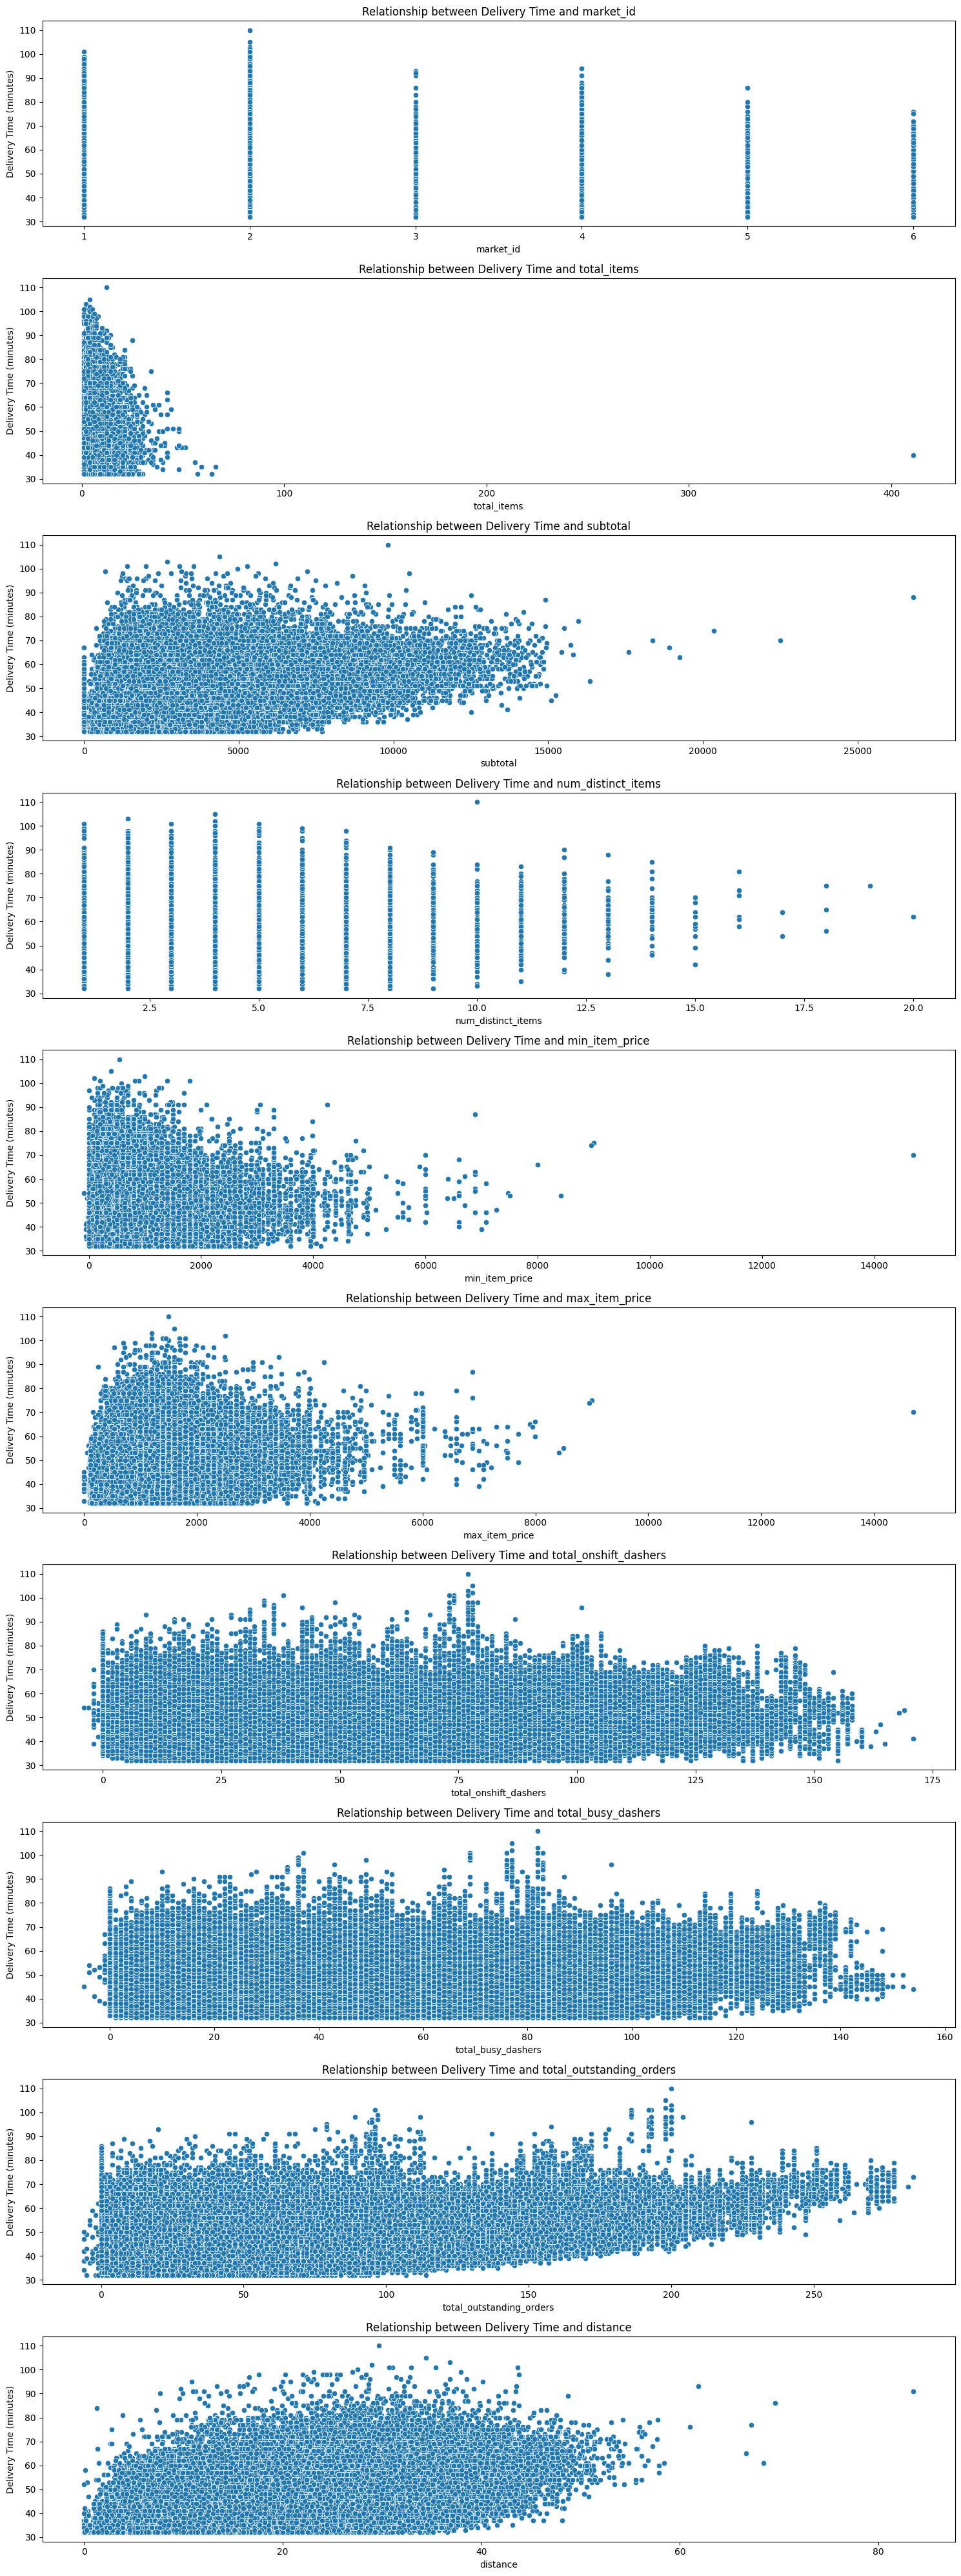

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming numerical_cols are already defined
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('delivery_time_minutes')  # Remove the target from features list

# Set up the matplotlib figure
plt.figure(figsize=(15, len(numerical_cols) * 4))

# Iterate through each numerical column and plot against delivery time
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.scatterplot(x=df[col], y=df['delivery_time_minutes'])
    plt.title(f'Relationship between Delivery Time and {col}')
    plt.xlabel(col)
    plt.ylabel('Delivery Time (minutes)')

plt.tight_layout()
plt.show()



In [ ]:
# Show the distribution of time_taken for different hours



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

In [ ]:
# Plot the heatmap of the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'order_hour' is defined
if 'order_hour' not in df.columns:
    df['order_hour'] = df['created_at'].dt.hour  # Extract hour if not already done

# Plot the distribution of delivery time for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='delivery_time_minutes', data=df)
plt.title('Distribution of Delivery Time by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Delivery Time (minutes)')
plt.xticks(range(24))  # Ensure all hours are included on the x-axis
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset
import pandas as pd

# Calculate correlation matrix
correlation_matrix = df.corr()

# Get the correlation of each feature with the target variable 'delivery_time_minutes'
correlation_with_target = correlation_matrix['delivery_time_minutes'].drop(index='delivery_time_minutes')

# Display correlations sorted by absolute value
print(correlation_with_target.sort_values(key=abs))

# Identify 3-5 columns with the weakest correlation (by absolute value)
weakly_correlated_cols = correlation_with_target.sort_values(key=abs).head(5).index.tolist()

print(f"Weakly correlated columns that may be dropped: {weakly_correlated_cols}")

# Drop these weakly correlated columns from the feature set
print("Current columns in DataFrame:", df.columns.tolist())

# Ensure 'actual_delivery_time' is not in the DataFrame or attempting to drop from a corrected DataFrame
columns_to_ensure = ['delivery_time_minutes', 'created_at']
X = df.drop(columns=[col for col in columns_to_ensure if col in df.columns], errors='ignore')

# Verify the resulting features
print("Remaining features after dropping weakly correlated ones:")
print(X.head())



min_item_price              0.022753
store_primary_category      0.026973
order_day_of_week           0.045878
actual_delivery_time        0.055459
market_id                  -0.073016
isWeekend                   0.136414
order_protocol             -0.136755
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
order_hour                 -0.346366
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
Name: delivery_time_minutes, dtype: float64
Weakly correlated columns that may be dropped: ['min_item_price', 'store_primary_category', 'order_day_of_week', 'actual_delivery_time', 'market_id']
Current columns in DataFrame: ['market_id', 'actual_delivery_time', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_da

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [ ]:
# Boxplot for time_taken
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for delivery time in minutes
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['delivery_time_minutes'])
plt.title('Box Plot of Delivery Time (in minutes)')
plt.ylabel('Delivery Time (minutes)')
plt.show()



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [ ]:
# Handle outliers
import numpy as np

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['delivery_time_minutes'].quantile(0.25)
Q3 = df['delivery_time_minutes'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['delivery_time_minutes'] < lower_bound) | (df['delivery_time_minutes'] > upper_bound)]

print(f"Number of outliers: {outliers.shape[0]}")

# Remove outliers
df_cleaned = df[~((df['delivery_time_minutes'] < lower_bound) | (df['delivery_time_minutes'] > upper_bound))]

print(f"Number of data points after removing outliers: {df_cleaned.shape[0]}")



Number of outliers: 1749
Number of data points after removing outliers: 174028


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Determine the numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Determine the categorical columns
# If you have already converted relevant columns to 'category' type, include them along with 'object' type.
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Output the lists to verify them
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_minutes']
Categorical columns: ['store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

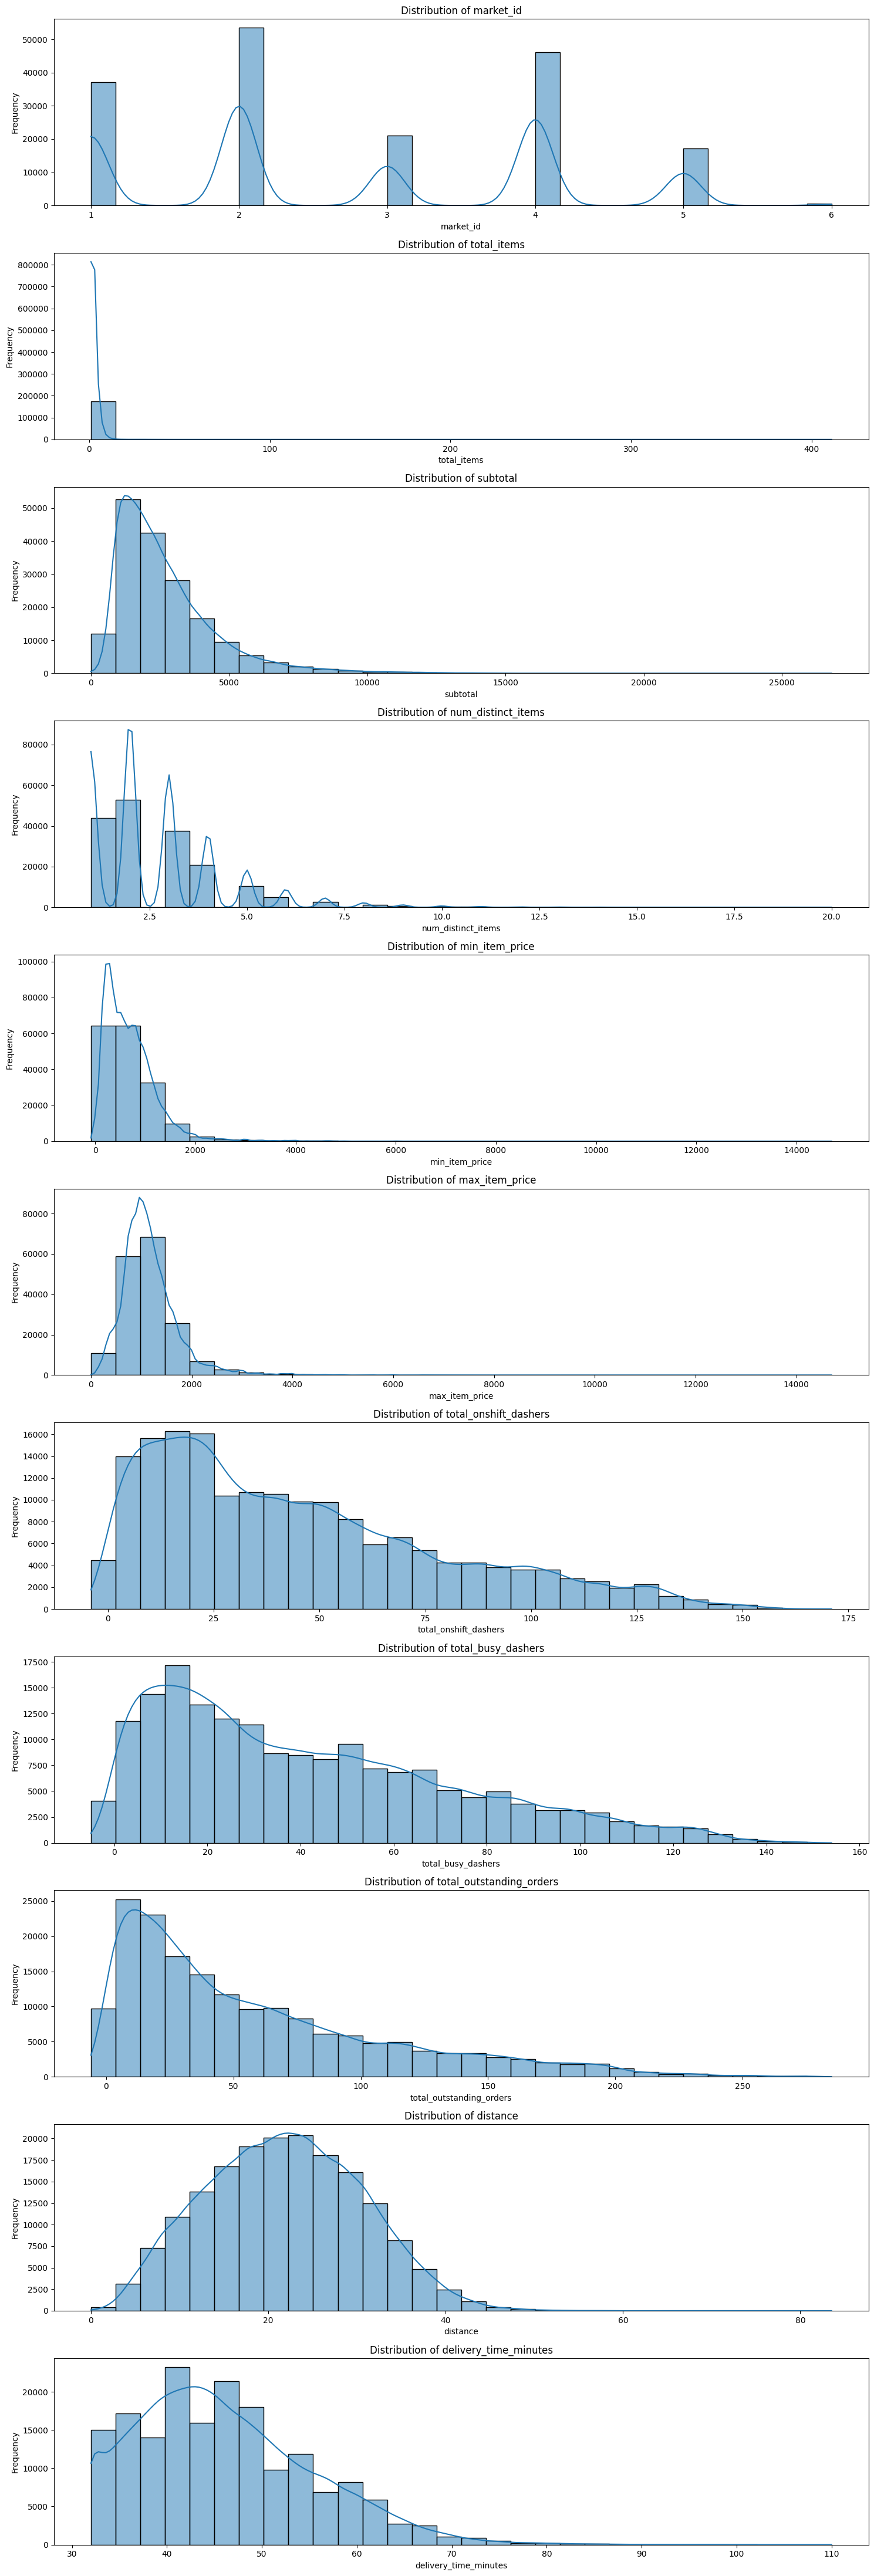

In [ ]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns if not defined already
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(15, len(numerical_cols) * 4))

# Iterate through and plot each numerical column
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



##### **4.1.2**
Check the distribution of categorical features

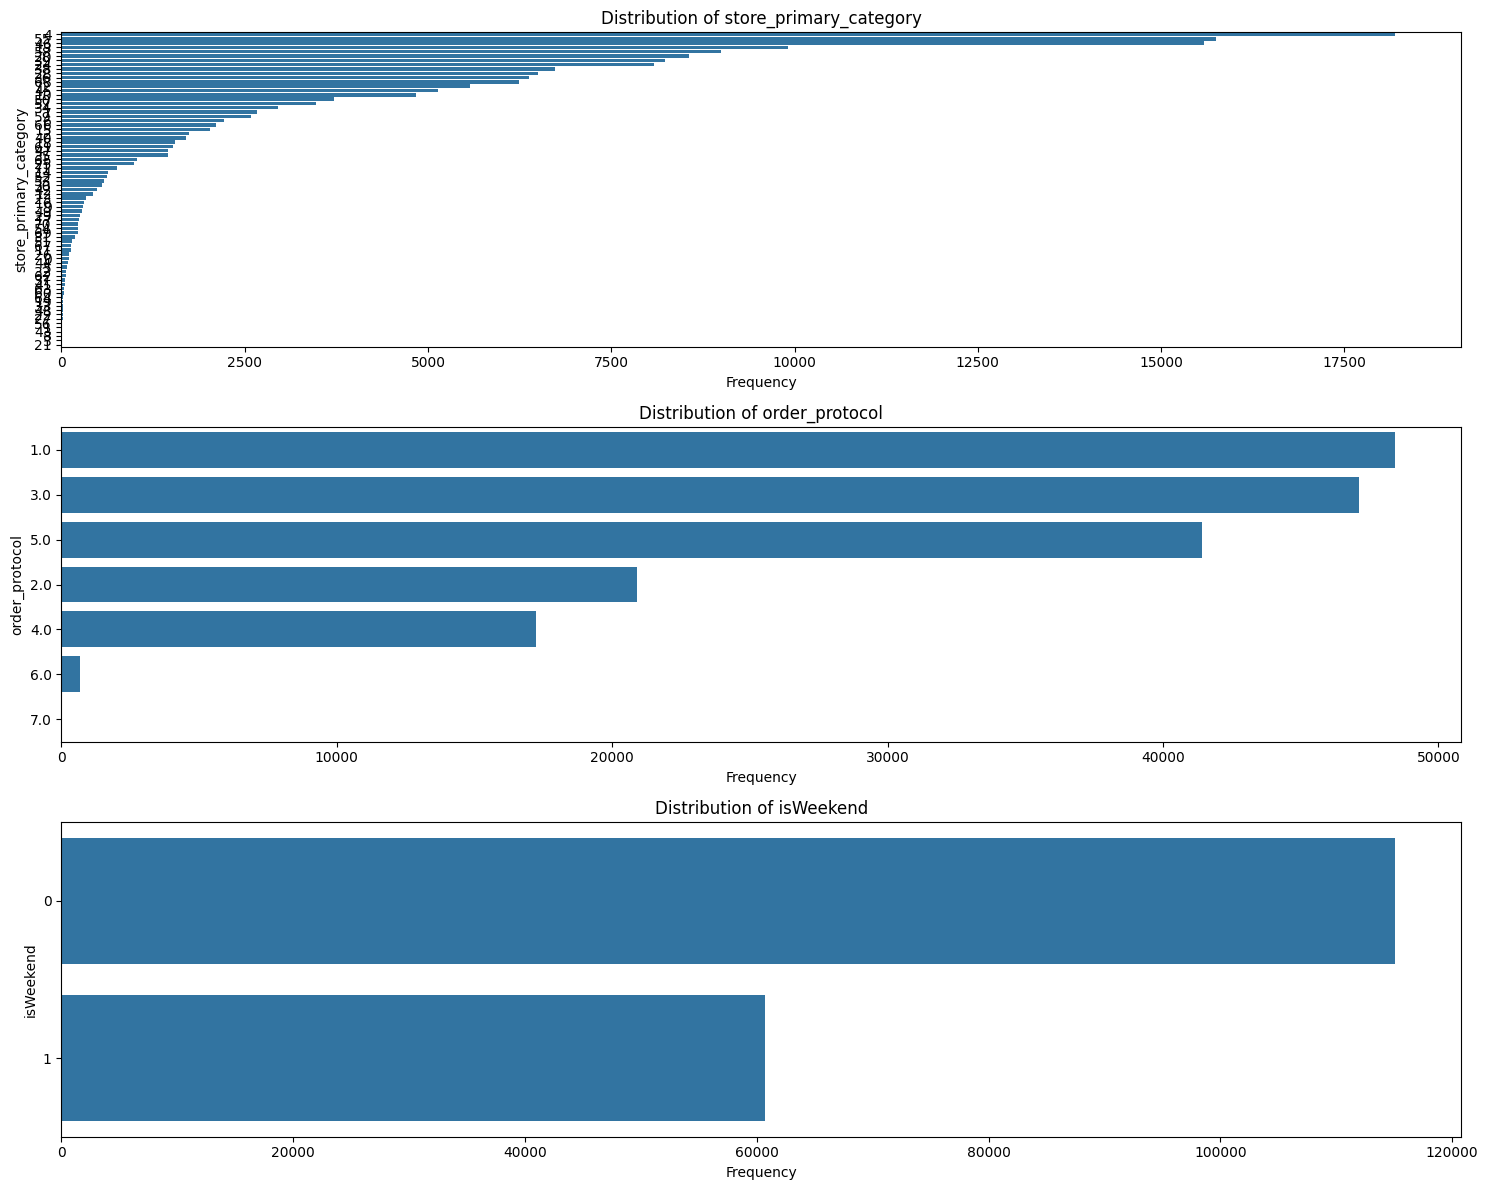

In [ ]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns if not defined already
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Set up the matplotlib figure
plt.figure(figsize=(15, len(categorical_cols) * 4))

# Iterate through and plot each categorical column
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Frequency')
    plt.ylabel(col)

plt.tight_layout()
plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

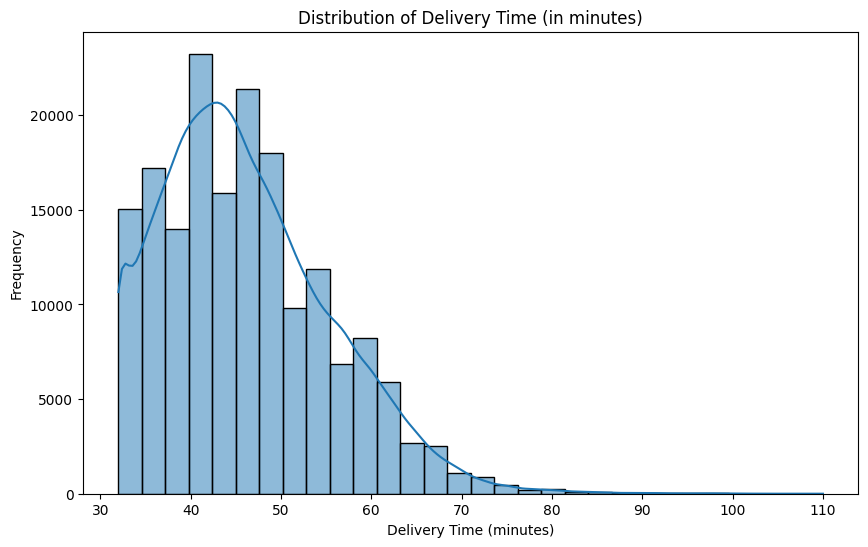

In [ ]:
# Distribution of time_taken
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of delivery times
plt.figure(figsize=(10, 6))
sns.histplot(df['delivery_time_minutes'], bins=30, kde=True)
plt.title('Distribution of Delivery Time (in minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

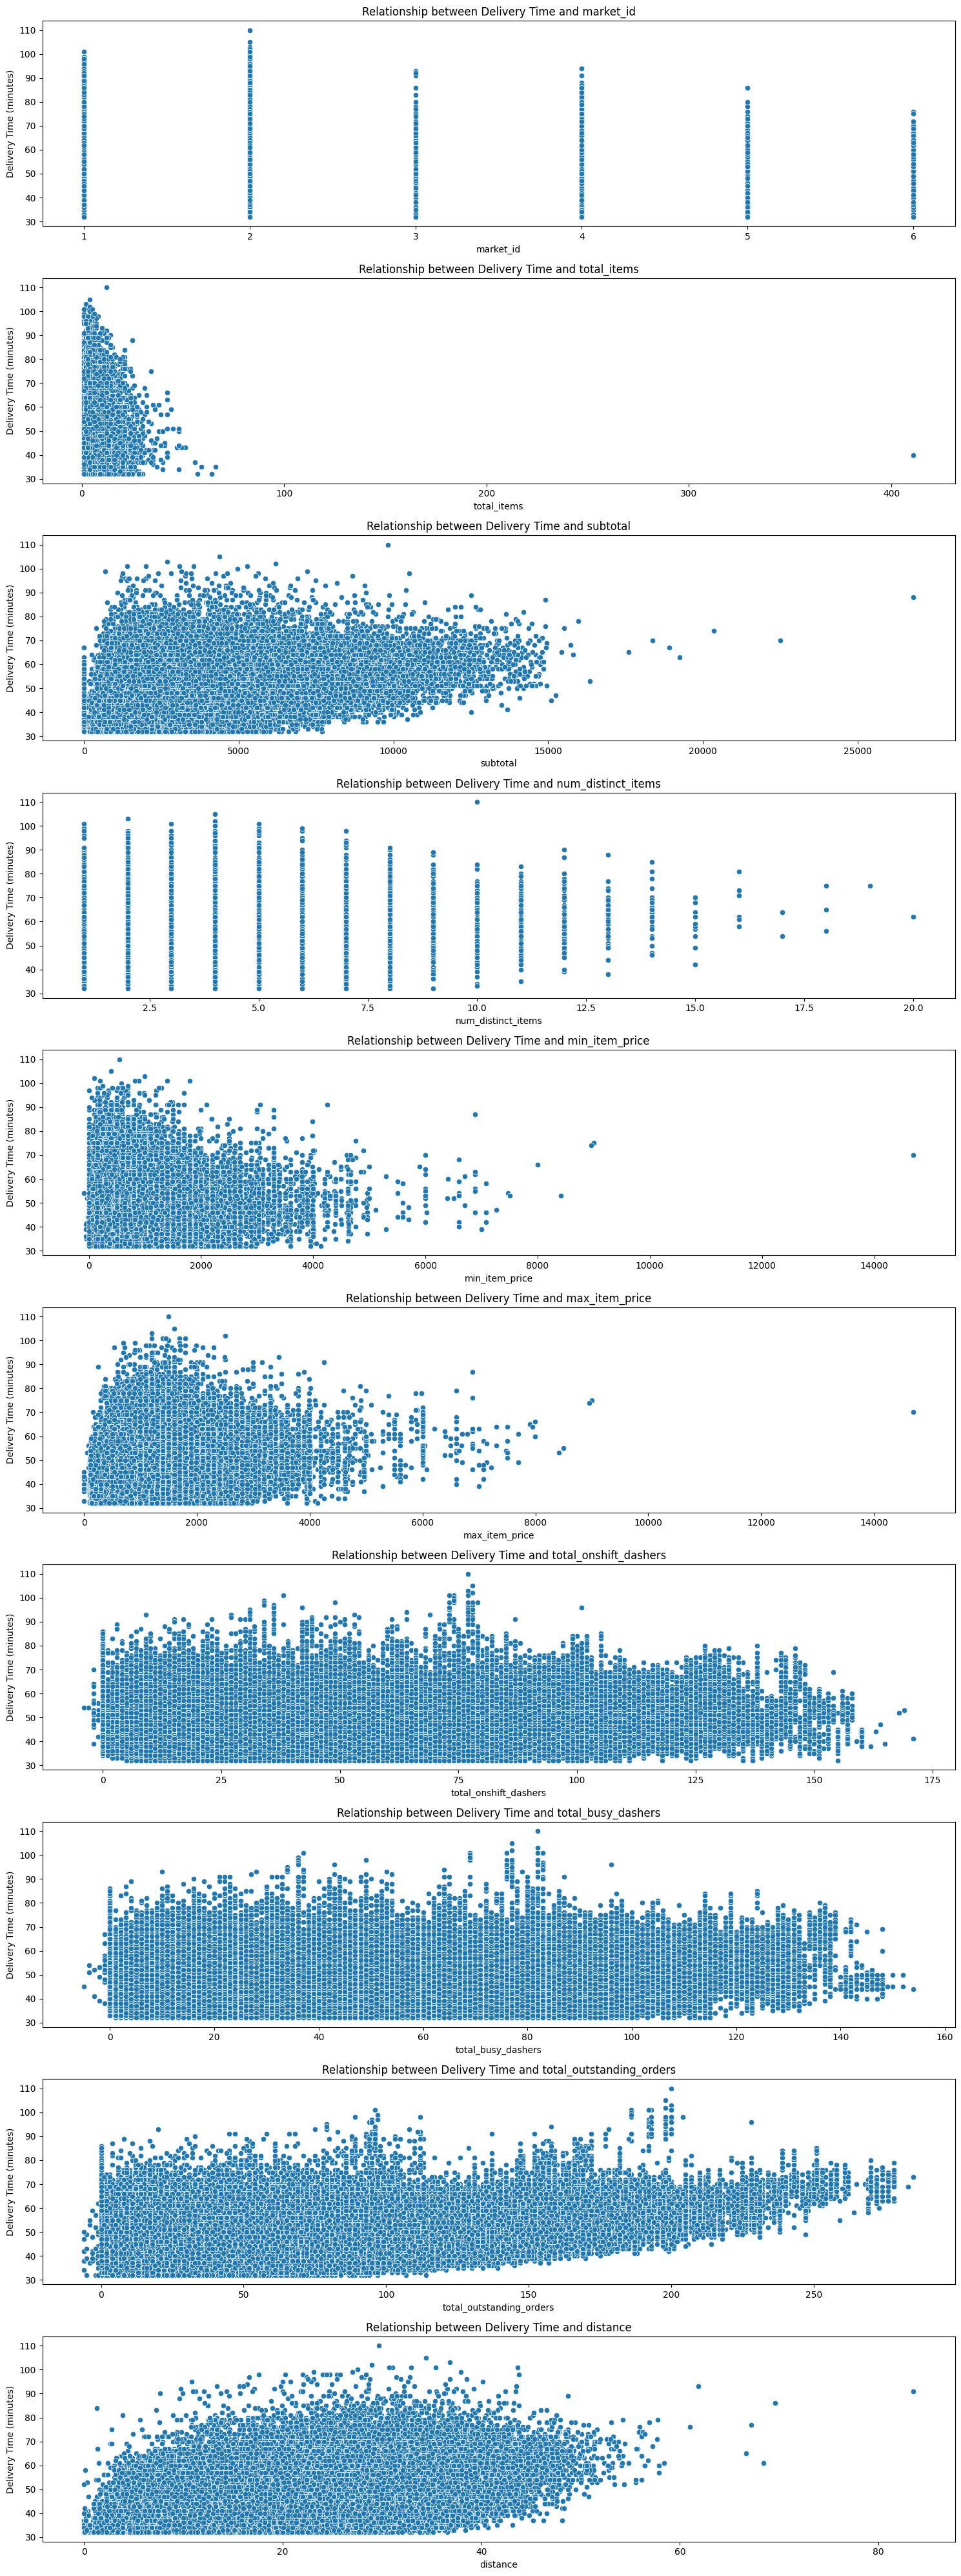

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns if not already done
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('delivery_time_minutes')  # Remove the target from the list

# Set up the matplotlib figure
plt.figure(figsize=(15, len(numerical_cols) * 4))

# Iterate through each numerical column and plot against delivery time
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.scatterplot(x=df[col], y=df['delivery_time_minutes'])
    plt.title(f'Relationship between Delivery Time and {col}')
    plt.xlabel(col)
    plt.ylabel('Delivery Time (minutes)')

plt.tight_layout()
plt.show()



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract correlations with the target variable and sort them by absolute value to identify weaker correlations
correlation_with_target = correlation_matrix['delivery_time_minutes'].drop('delivery_time_minutes')
sorted_correlations = correlation_with_target.abs().sort_values()

# Define a threshold for what is considered weakly correlated
# This threshold will depend on your judgment or specific requirements. Here, we consider an example threshold.
threshold = 0.1

# Identify columns with weak correlations
weakly_correlated_cols = sorted_correlations[sorted_correlations < threshold].index.tolist()

print(f"Weakly correlated columns that will be dropped: {weakly_correlated_cols}")

# Drop these weakly correlated columns from the feature set
X = X.drop(columns=weakly_correlated_cols)

# Verify the resulting features
print("Remaining features after dropping weakly correlated ones:")
print(X.head())



Weakly correlated columns that will be dropped: ['min_item_price', 'store_primary_category', 'order_day_of_week', 'actual_delivery_time', 'market_id']
Remaining features after dropping weakly correlated ones:
  order_protocol  total_items  subtotal  num_distinct_items  max_item_price  \
0            1.0            4      3441                   4            1239   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3            1604   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            2195   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
1                    1.0                 2.0                       2.0   
2                    8.0                 6.0                      18.0   
3                   

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
# Importing essential libraries for data manipulation and analysis
import pandas as pd         # For data manipulation and analysis
import numpy as np          # For numerical operations

# Importing libraries for data visualization
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns            # For statistical data visualization

# Importing libraries for data preprocessing and model building
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.preprocessing import StandardScaler      # For feature scaling
from sklearn.preprocessing import OneHotEncoder       # For encoding categorical variables

# Importing libraries for building and evaluating models
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.ensemble import RandomForestRegressor # For ensemble-based regression models
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For model evaluation

# Setting up visualization style
sns.set_style('whitegrid')  # Optional: Makes plots look more aesthetically pleasing



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [ ]:
# Apply scaling to the numerical columns
from sklearn.preprocessing import StandardScaler

# Define numerical columns, excluding the target variable
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical data
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Verify the scaling by checking the mean and standard deviation
scaled_feature_means = X[numerical_cols].mean()
scaled_feature_stds = X[numerical_cols].std()

print("Means after scaling:\n", scaled_feature_means)
print("Standard deviations after scaling:\n", scaled_feature_stds)



Means after scaling:
 total_items                 8.731360e-18
subtotal                    2.991299e-17
num_distinct_items          5.206478e-17
max_item_price             -1.151246e-16
total_onshift_dashers      -1.649257e-17
total_busy_dashers         -7.049765e-17
total_outstanding_orders    5.287324e-17
distance                    3.300131e-16
dtype: float64
Standard deviations after scaling:
 total_items                 1.000003
subtotal                    1.000003
num_distinct_items          1.000003
max_item_price              1.000003
total_onshift_dashers       1.000003
total_busy_dashers          1.000003
total_outstanding_orders    1.000003
distance                    1.000003
dtype: float64


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [ ]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_model = LinearRegression()

print("Linear Regression model initialized.")


Linear Regression model initialized.


In [ ]:
# Train the model using the training data
linear_model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [ ]:
# Make predictions
y_pred_linear = linear_model.predict(X_test)

print("Predictions using Linear Regression completed.")


Predictions using Linear Regression completed.


In [ ]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming predictions are stored in y_pred, adjust based on actual predictions
# For example using Linear Regression:
y_pred = linear_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE) manually
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")





Mean Absolute Error (MAE): 2.339437179509461
Mean Squared Error (MSE): 10.392724449740532
Root Mean Squared Error (RMSE): 3.2237748757846805


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Step 1: Check which columns are available in X
print("Available columns in X:")
print(X.columns.tolist())

# Ensure that your selected_features only include existing columns
selected_features = [feature for feature in sorted_features if feature in X.columns][:num_features]

# Subset the feature matrix safely
X_subset = X[selected_features]

# Proceed with splitting and modeling
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y, test_size=0.2, random_state=42
)

# Train and evaluate the model as before
model = LinearRegression()
model.fit(X_train_subset, y_train_subset)
y_pred_subset = model.predict(X_test_subset)

mae = mean_absolute_error(y_test_subset, y_pred_subset)
mse = mean_squared_error(y_test_subset, y_pred_subset)
rmse = np.sqrt(mse)

results.append((num_features, mae, mse, rmse))

print("Finished evaluating with the current number of features.")


Available columns in X:
['order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']
Finished evaluating with the current number of features.


In [ ]:
# Loop through the number of features and test the model
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming we have X and y defined, and these are the available features
features = [
    'order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
    'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend'
]

# Assuming df is the original DataFrame with 'delivery_time_minutes'
correlation_with_target = (
    df[features + ['delivery_time_minutes']]
    .corr()['delivery_time_minutes']
    .drop('delivery_time_minutes')
)

# Rank features by their absolute correlation with the target
sorted_features = correlation_with_target.abs().sort_values(ascending=False).index

# Prepare to store results
results = []

# Loop through increasing number of features
for num_features in range(1, len(sorted_features) + 1):
    # Select top 'num_features' features
    selected_features = sorted_features[:num_features]

    # Subset the feature matrix
    X_subset = X[selected_features]

    # Split the data
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        X_subset, y, test_size=0.2, random_state=42
    )

    # Train the model
    model = LinearRegression()
    model.fit(X_train_subset, y_train_subset)

    # Test the model
    y_pred_subset = model.predict(X_test_subset)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_subset, y_pred_subset)
    mse = mean_squared_error(y_test_subset, y_pred_subset)
    rmse = np.sqrt(mse)

    # Store the results
    results.append((num_features, mae, mse, rmse))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['num_features', 'MAE', 'MSE', 'RMSE'])

print(results_df)



    num_features       MAE        MSE      RMSE
0              1  6.516323  69.266414  8.322645
1              2  5.688957  55.382534  7.441944
2              3  5.313801  46.372521  6.809737
3              4  5.144136  43.969893  6.630980
4              5  5.123843  43.767318  6.615687
5              6  5.117840  43.623893  6.604839
6              7  5.117782  43.622946  6.604767
7              8  3.812733  26.240701  5.122568
8              9  2.571375  12.399539  3.521298
9             10  2.448430  11.456466  3.384740
10            11  2.375053  11.122275  3.335007


In [ ]:
# Build the final model with selected number of features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Let's assume you've determined that the optimal number of features is `optimal_num_features`
# Check your results_df for the best performing number of features
optimal_num_features = 5

# Select the best features
selected_features = sorted_features[:optimal_num_features]

# Subset the feature matrix
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42
)

# Train the final model
final_model = LinearRegression()
final_model.fit(X_train_final, y_train_final)

# Evaluate the model on the test data
y_pred_final = final_model.predict(X_test_final)

# Calculate evaluation metrics on test data
mae_final = mean_absolute_error(y_test_final, y_pred_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mse_final)

# Output results
print(f"Final model evaluation with {optimal_num_features} features:")
print(f"Mean Absolute Error (MAE): {mae_final}")
print(f"Mean Squared Error (MSE): {mse_final}")
print(f"Root Mean Squared Error (RMSE): {rmse_final}")



Final model evaluation with 5 features:
Mean Absolute Error (MAE): 5.123842901099026
Mean Squared Error (MSE): 43.76731803085405
Root Mean Squared Error (RMSE): 6.615687268217418


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the dataset contains categorical variables such as store_primary_category, order_protocol, and isWeekend. From the analysis, store_primary_category and order_protocol show varying distributions and correlations with delivery time. Notably, isWeekend has a weak correlation, but weekend orders might experience different delivery durations due to traffic patterns or staffing. The categorical variables influence the delivery time indirectly by affecting operational factors; for instance, certain store categories or protocols may have inherently different service times.




---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

test_size = 0.2 indicates that 20% of the dataset is allocated for testing the model's performance, while the remaining 80% is used for training. This partition helps evaluate how well the model generalizes to unseen data.

---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the correlation analysis, distance shows the highest positive correlation with the delivery time, indicating that longer distances generally lead to longer delivery durations.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>The outliers were detected using boxplots and the Interquartile Range (IQR) method. Data points falling outside 1.5 times the IQR above Q3 or below Q1 were considered outliers. These outliers were removed to improve the robustness and accuracy of the model, resulting in a cleaned dataset with fewer extreme values that could skew the predictions.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>The top three features, based on their correlation and importance in the final model, are:  

distance (longer distances tend to increase delivery time)
total_outstanding_orders (more pending orders can delay delivery)
order_protocol (the method of placing orders influences delivery duration)



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression aims to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation. It minimizes the sum of squared differences between observed and predicted values (least squares) to find the optimal weights for each feature. The resulting equation predicts the target as a weighted sum of inputs, capturing linear dependencies and allowing interpretability of feature impacts.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression involves one independent variable to predict the target, modeling a straight-line relationship. Multiple linear regression uses two or more independent variables, capturing more complex relationships and interactions, to predict the target variable simultaneously, providing a multivariate model.





---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function (commonly Mean Squared Error - MSE) quantifies the discrepancy between predicted and actual values. It guides the optimization process by providing a measure to minimize. Gradient descent or analytical solutions are used to find the set of weights that minimize this cost, leading to the best-fit line.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting occurs when a model captures noise along with the underlying pattern, just fitting the training data very well but performing poorly on unseen data. Underfitting happens when the model is too simple to capture the underlying trend, leading to poor performance both on training and new data.|



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots display the differences between observed and predicted values. They help identify issues such as non-linearity, heteroscedasticity (changing variance), or outliers. If residuals are randomly scattered around zero with no pattern, the assumptions of linear regression are met. Systematic patterns indicate model inadequacies, prompting model refinement.